# Homework05

Some exercises with image and audio data preparation.

## Goals

- Even more practice with lists
- Get familiar with pandas `DataFrames`
- Practice dataset exploration and normalization/scaling
- Set up a dataset for proper classification

## Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework

In [1]:
!wget -q https://github.com/PSAM-5020-2026S-A/5020-utils/raw/main/src/audio_utils.py
!wget -q https://github.com/PSAM-5020-2026S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2026S-A/5020-utils/raw/main/src/image_utils.py

!wget -q https://github.com/PSAM-5020-2026S-A/Homework03/raw/main/Homework03_utils.pyc
!wget -q https://github.com/PSAM-5020-2026S-A/Homework04/raw/main/Homework04_utils.pyc

!wget -qO- https://github.com/PSAM-5020-2026S-A/5020-utils/releases/latest/download/forest-tree.tar.gz | tar xz
!wget -qO- https://github.com/PSAM-5020-2026S-A/5020-utils/releases/latest/download/instruments.tar.gz | tar xz

!wget -q https://github.com/PSAM-5020-2026S-A/5020-utils/raw/refs/heads/main/datasets/audio/hood-internet.tar.gz
!tar -xzf ./hood-internet.tar.gz -C ./data/audio/ && rm -rf hood-internet.tar.gz

In [1]:
import librosa
import matplotlib.pyplot as plt
import pandas as pd 
import random

from IPython.display import Audio
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from os import listdir

from image_utils import make_image, get_pixels

from Homework05_utils import AwesomeAudioClassifier, AwesomeImageClassifier

AUDIO_PATH = "./data/audio/instruments/test"
IMAGE_PATH = "./data/image/forest-tree/test"

## More Image/Audio Classification

We're going to re-visit the classification exercises from `Homework04` and `Homework05`.

This exercise is a bit different though. In some ways it's the opposite of the previous exercises because we'll already have classification models ready to be used, but will have to normalize and standardize our dataset in order to run them. This is more representative of the type of work that goes into using real, pre-trained, ML models in the wild.

### The Models

We have two `Awesome` models, one for audio classification (`AwesomeAudioClassifier`), and one for image classification (`AwesomeImageClassifier`).

Unlike the classification models we set up for `Homework04` and `Homework05`, these models have more strict requirements about the shape and values of their input data. We can't run them on the files as they are.

### The Data

Audio and Image files are in the `data/audio/` and `data/image/` directories respectively.

We will use the `get_training_data()` from each of our classifiers to get the initial training data and labels for our audio and image files.

### The Features

This is the challenging part.

The data returned by `get_training_data()` is a representation of the content of the audio and image files, but it hasn't been processed or normalized in order to be used by the classifier models provided.

We can try to create a `DataFrame` directly from those, and it might seem like it works, but if we take a look at the result we'll see some `NaN` (Not-a-Number) values in some of the columns, and if we send that to the model it will barf and complain about having `NaN`s in the data.

This happens because all of the audios and images have different sizes. Hoooray !!

Welcome to Machine Learning. This is probably where most of the time in any ML project is spent: cleaning up data and making sure it has the right format, size and shape that a model expects.

For this exercise it won't be too hard to fix these.

Let's start with the audio files since they're one-dimensional, and once we have the audio modeling working we'll come back to the image files.

## Audio Data

Let's run `AwesomeAudioClassifier.get_training_data()` function to get some audio data. This function returns audio data and labels from files inside a specified directory.

In [2]:
features, labels = AwesomeAudioClassifier.get_training_data(AUDIO_PATH)

### Audio Features

The audio data returned is actually in the frequency domain and is not samples, so even though we can't play these audio files, we can still plot this data and will have to normalize and clean it before we can run it through our classifier.

Let's take a look at this data.

What are the labels ? How many records do we have ? How many features do we have in each record ? Can we plot our data ?

Number of records: 79
Number of feature lists: 79
Features per record: 43417


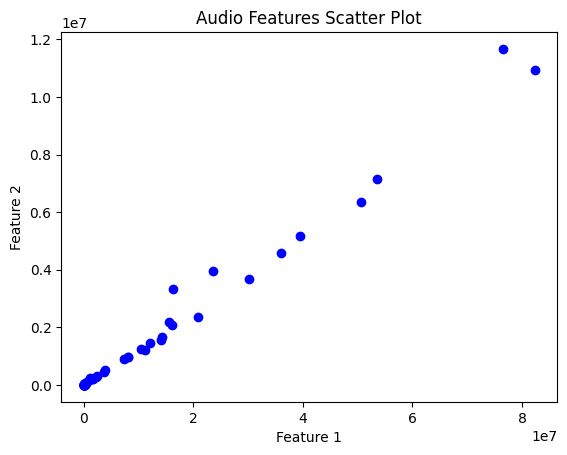

In [3]:
# TODO: How many records ?
print(f"Number of records: {len(labels)}")
print(f"Number of feature lists: {len(features)}")
print(f"Features per record: {len(features[0])}")

# Plot some features
plt.scatter([f[0] for f in features], [f[1] for f in features], c='blue')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Audio Features Scatter Plot")
plt.show()

### Looks like data !

Looks like audio frequency-domain data to be more specific.

If we were to follow some of the data exploration steps we saw in class we would want to put this data in a `DataFrame` in order to get calculate some of its statistical properties, and maybe scale/normalize it before we use it in a classifier model.

Let's try it:

In [4]:
features_df = pd.DataFrame(features)
features_df

0           1       2       3       4      5       6       7      \
0       2209.0       172.0    39.0     2.0     0.0    1.0    14.0    29.0   
1   10442599.0   1261512.0    24.0    30.0    40.0   50.0   122.0    78.0   
2     153391.0     24877.0   241.0    42.0    66.0   80.0    99.0    84.0   
3   76499275.0  11668549.0  3906.0   107.0   394.0   32.0   234.0  2760.0   
4   14136394.0   1554687.0   352.0    10.0    67.0  550.0  1933.0  1559.0   
..         ...         ...     ...     ...     ...    ...     ...     ...   
74  14259369.0   1647369.0   419.0     8.0    77.0  737.0  1993.0  2045.0   
75    670788.0    118085.0   260.0     0.0    36.0   24.0     2.0    29.0   
76  82316585.0  10953710.0  3289.0  1423.0   389.0   12.0    31.0  3726.0   
77      4055.0       496.0     0.0     0.0     0.0    0.0     0.0     0.0   
78  20865067.0   2362673.0   122.0   870.0  2574.0   84.0   231.0  3068.0   

     8      9      ...  43533  43534  43535  43536  43537  43538  43539  \
0    147.0   28.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    117.0   62.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2     72.0   47.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3   3923.0   38.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4   1288.0  164.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..     ...    ...  ...    ...    ...    ...    ...    ...    ...    ...   
74  1411.0  178.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
75     9.0   10.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
76  6086.0  398.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
77     0.0    0.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
78  5525.0  125.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

    43540  43541  43542  
0     NaN    NaN    NaN  
1     NaN    NaN    NaN  
2     0.0    NaN    NaN  
3     NaN    NaN    NaN  
4     NaN    NaN    NaN  
..    ...    ...    ...  
74    NaN    NaN    NaN  
75    NaN    NaN    NaN  
76    NaN    NaN    NaN  
77    NaN    NaN    NaN  
78    NaN    NaN    NaN  

[79 rows x 43543 columns]

It looks like it works, but when we look closely at the `DataFrame`, specially if we look at the features that are further to the right, we'll see our problem: `NaN` values.

As previously mentioned, this happens because the length of our features is different for each file.

### Fix Audio Data

Let's fix this by making all of the feature lists have the same length. We can either pad the short ones or slice the longer ones to have the same length as the shortest feature list. The second option is preferable since padding would require adding information to the dataset and that might have side effects.

So, we'll go through the lists of lists, create a list of lengths and find the smallest length.

Then, we'll iterate through the lists of lists and slice all the feature lists to have the same length.

In [5]:
# TODO: go through the list of features and make their lengths consistent
min_length = min(len(f) for f in features) # this will extract each row lenght
cropped_features = [f[:min_length] for f in features]

A `DataFrame` created using the cropped features should look more consistent now.

In [6]:
features_df = pd.DataFrame(cropped_features)
features_df

0           1       2       3       4      5       6       7      \
0       2209.0       172.0    39.0     2.0     0.0    1.0    14.0    29.0   
1   10442599.0   1261512.0    24.0    30.0    40.0   50.0   122.0    78.0   
2     153391.0     24877.0   241.0    42.0    66.0   80.0    99.0    84.0   
3   76499275.0  11668549.0  3906.0   107.0   394.0   32.0   234.0  2760.0   
4   14136394.0   1554687.0   352.0    10.0    67.0  550.0  1933.0  1559.0   
..         ...         ...     ...     ...     ...    ...     ...     ...   
74  14259369.0   1647369.0   419.0     8.0    77.0  737.0  1993.0  2045.0   
75    670788.0    118085.0   260.0     0.0    36.0   24.0     2.0    29.0   
76  82316585.0  10953710.0  3289.0  1423.0   389.0   12.0    31.0  3726.0   
77      4055.0       496.0     0.0     0.0     0.0    0.0     0.0     0.0   
78  20865067.0   2362673.0   122.0   870.0  2574.0   84.0   231.0  3068.0   

     8      9      ...  42990  42991  42992  42993  42994  42995  42996  \
0    147.0   28.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    117.0   62.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2     72.0   47.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3   3923.0   38.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4   1288.0  164.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
..     ...    ...  ...    ...    ...    ...    ...    ...    ...    ...   
74  1411.0  178.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
75     9.0   10.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
76  6086.0  398.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
77     0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
78  5525.0  125.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

    42997  42998  42999  
0     0.0    0.0    0.0  
1     0.0    0.0    0.0  
2     0.0    0.0    0.0  
3     0.0    0.0    0.0  
4     0.0    0.0    0.0  
..    ...    ...    ...  
74    0.0    0.0    0.0  
75    0.0    0.0    0.0  
76    0.0    0.0    0.0  
77    0.0    0.0    0.0  
78    0.0    0.0    0.0  

[79 rows x 43000 columns]

### Bonus: Empty features

We've removed the `NaN` values, but it seems like we have a lot of columns that are all zeros or nearly all zeros, or are full of values that are close to zero, like `1e-7`.

While it's not necessary, we could also remove these in order to speed up the modeling later.

The `.loc[]` accessor of the `DataFrame` can be used to select columns using boolean indexing.

In [7]:
# sum of all columns
display(features_df.sum())

# columns where the sum is more than 100
display((features_df.sum() > 100))

# TODO: remove columns with no information
filtered_features_df = features_df.loc[:, features_df.sum() > 100] # using a boolean mask to filter the columns
filtered_features_df

0        567486224.0
1         76548890.0
2            59018.0
3            14074.0
4            18666.0
            ...     
42995            1.0
42996            0.0
42997            0.0
42998            0.0
42999            1.0
Length: 43000, dtype: float64

0         True
1         True
2         True
3         True
4         True
         ...  
42995    False
42996    False
42997    False
42998    False
42999    False
Length: 43000, dtype: bool

0           1       2       3       4      5       6       7      \
0       2209.0       172.0    39.0     2.0     0.0    1.0    14.0    29.0   
1   10442599.0   1261512.0    24.0    30.0    40.0   50.0   122.0    78.0   
2     153391.0     24877.0   241.0    42.0    66.0   80.0    99.0    84.0   
3   76499275.0  11668549.0  3906.0   107.0   394.0   32.0   234.0  2760.0   
4   14136394.0   1554687.0   352.0    10.0    67.0  550.0  1933.0  1559.0   
..         ...         ...     ...     ...     ...    ...     ...     ...   
74  14259369.0   1647369.0   419.0     8.0    77.0  737.0  1993.0  2045.0   
75    670788.0    118085.0   260.0     0.0    36.0   24.0     2.0    29.0   
76  82316585.0  10953710.0  3289.0  1423.0   389.0   12.0    31.0  3726.0   
77      4055.0       496.0     0.0     0.0     0.0    0.0     0.0     0.0   
78  20865067.0   2362673.0   122.0   870.0  2574.0   84.0   231.0  3068.0   

     8      9      ...  21805  21806  24000  25434  25435  25436  25437  \
0    147.0   28.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1    117.0   62.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2     72.0   47.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3   3923.0   38.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4   1288.0  164.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
..     ...    ...  ...    ...    ...    ...    ...    ...    ...    ...   
74  1411.0  178.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
75     9.0   10.0  ...    0.0    0.0    0.0    2.0    2.0    2.0    1.0   
76  6086.0  398.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
77     0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
78  5525.0  125.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

    25438  25439  28984  
0     0.0    0.0    0.0  
1     0.0    0.0    0.0  
2     0.0    0.0    0.0  
3     0.0    0.0    0.0  
4     0.0    0.0    0.0  
..    ...    ...    ...  
74    0.0    0.0    0.0  
75    1.0    0.0    0.0  
76    0.0    0.0    0.0  
77    0.0    0.0    0.0  
78    0.0    0.0    0.0  

[79 rows x 8435 columns]

### Run the Model

Now that we have a `DataFrame` with consistent rows, we can fit and evaluate our model.

The next cell runs the pre-defined classification model, fitting it with our `features_df` `DataFrame` and then reports the accuracy of our model.

We just have to run it.

In [8]:
# Fit the classifier and report training accuracy
AwesomeAudioClassifier.fit(features_df, labels)

training accuracy: {'clarinet': 0.6, 'guitar': 1.0, 'piano': 0.0, 'overall': 0.53333}


### Scale / Normalize

Hmmm.... it runs, but we can do better.

We saw in class that normalizing/rescaling our features can help us find actual patterns in our data. It also helps models find patterns.

Try scaling the `DataFrame` using either a `MinMaxScaler` or a `StandardScaler` object.

In [9]:
# TODO: scale/normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)
AwesomeAudioClassifier.fit(scaled_features, labels)

training accuracy: {'clarinet': 0.8, 'guitar': 0.7931, 'piano': 1.0, 'overall': 0.86437}


### Run the Model Again

This time with scaled data.

In [10]:
# Fit the classifier and report training accuracy
features_scaled_df = pd.DataFrame(scaled_features)
AwesomeAudioClassifier.fit(features_scaled_df, labels)
features_scaled_df


training accuracy: {'clarinet': 0.8, 'guitar': 0.7931, 'piano': 1.0, 'overall': 0.86437}


0         1         2         3         4         5         6      \
0  -0.445743 -0.435935 -0.388470 -0.370459 -0.463666 -0.269175 -0.207421   
1   0.202304  0.131635 -0.396700 -0.311573 -0.385171 -0.145204 -0.010939   
2  -0.436359 -0.424818 -0.277645 -0.286336 -0.334149 -0.069303 -0.052782   
3   4.302517  4.814527  1.733111 -0.149637  0.309508 -0.190744  0.192821   
4   0.431582  0.263556 -0.216746 -0.353634 -0.332187  1.119806  3.283785   
..       ...       ...       ...       ...       ...       ...       ...   
74  0.439215  0.305260 -0.179988 -0.357840 -0.312563  1.592920  3.392942   
75 -0.404243 -0.382877 -0.267221 -0.374665 -0.393020 -0.210984 -0.229253   
76  4.663604  4.492868  1.394601  2.617996  0.299696 -0.241345 -0.176494   
77 -0.445628 -0.435789 -0.409867 -0.374665 -0.463666 -0.271705 -0.232891   
78  0.849238  0.627128 -0.342933  1.455001  4.587473 -0.059183  0.187363   

       7         8         9      ...  42990  42991  42992  42993     42994  \
0  -0.418568 -0.402271 -0.243515  ...    0.0    0.0    0.0    0.0 -0.113228   
1  -0.357974 -0.421426 -0.146843  ...    0.0    0.0    0.0    0.0 -0.113228   
2  -0.350555 -0.450159 -0.189492  ...    0.0    0.0    0.0    0.0 -0.113228   
3   2.958607  2.008751 -0.215082  ...    0.0    0.0    0.0    0.0 -0.113228   
4   1.473441  0.326272  0.143172  ...    0.0    0.0    0.0    0.0 -0.113228   
..       ...       ...       ...  ...    ...    ...    ...    ...       ...   
74  2.074433  0.404809  0.182978  ...    0.0    0.0    0.0    0.0 -0.113228   
75 -0.418568 -0.490385 -0.294694  ...    0.0    0.0    0.0    0.0 -0.113228   
76  4.153170  3.389853  0.808500  ...    0.0    0.0    0.0    0.0 -0.113228   
77 -0.454430 -0.496132 -0.323127  ...    0.0    0.0    0.0    0.0 -0.113228   
78  3.339482  3.031648  0.032284  ...    0.0    0.0    0.0    0.0 -0.113228   

       42995  42996  42997  42998     42999  
0  -0.113228    0.0    0.0    0.0 -0.113228  
1  -0.113228    0.0    0.0    0.0 -0.113228  
2  -0.113228    0.0    0.0    0.0 -0.113228  
3  -0.113228    0.0    0.0    0.0 -0.113228  
4  -0.113228    0.0    0.0    0.0 -0.113228  
..       ...    ...    ...    ...       ...  
74 -0.113228    0.0    0.0    0.0 -0.113228  
75 -0.113228    0.0    0.0    0.0 -0.113228  
76 -0.113228    0.0    0.0    0.0 -0.113228  
77 -0.113228    0.0    0.0    0.0 -0.113228  
78 -0.113228    0.0    0.0    0.0 -0.113228  

[79 rows x 43000 columns]

### Interpretation

<span style="color:hotpink;">
Do different scaling strategies influence the prediction results ? What might that tell us about our data ?
</span>

<span style="color:hotpink;">
EDIT THIS CELL WITH ANSWER
</span>

The sacling method tends to make the value more stable in training I guess, and it will smooth out the prediction pattern and result, I think after scaling the data have much smaller range, it could be the standard deviation value. 

## Image Data

This is a bit trickier, but only because our classifier model for images is a bit pickier. Not only do we have to ensure that all of our records have the same number of features (images have the same number of pixels), we will also have to convert the pixels into grayscale pixels.

Let's start by reading the data and looking at what we get.

In [11]:
imgs, labels = AwesomeImageClassifier.get_training_data(IMAGE_PATH)

### Image Data

What did we get in the `imgs` variable ? How many records do we have ? How many features does each record/image have ?

In [12]:
# TODO: look at the imgs and labels variables and get some information about the data
print(f"Number of images: {len(imgs)}")
print(f"Number of labels: {len(labels)}")
print(f"Unique labels: {set(labels)}")

Number of images: 127
Number of labels: 127
Unique labels: {'forest', 'tree', 'florist'}


### Create Image Features

It seems like we have actual `PIL` image objects and their labels. 

This will work to our advantage because if we try to just create a `DataFrame` of the extracted pixels from these images we'll probably have a problem with missing feature values again.

In [13]:
features = []
for img in imgs:
  features.append(get_pixels(img))

print(len(features), len(features[0]), len(features[11]))

features_df = pd.DataFrame(features)
features_df

127 42436 26896


0                1                2                3      \
0    (228, 203, 183)  (228, 203, 183)  (228, 203, 183)  (228, 203, 183)   
1    (213, 214, 208)  (216, 217, 211)  (218, 219, 213)  (218, 219, 213)   
2    (136, 164, 203)  (136, 164, 203)  (136, 164, 203)  (136, 164, 203)   
3    (255, 255, 255)  (255, 255, 255)  (255, 255, 255)  (255, 255, 255)   
4       (30, 46, 14)     (53, 68, 38)     (28, 43, 16)      (10, 21, 3)   
..               ...              ...              ...              ...   
122  (238, 238, 238)  (238, 238, 238)  (238, 238, 238)  (238, 238, 238)   
123     (12, 12, 12)     (12, 12, 12)     (12, 12, 12)     (12, 12, 12)   
124     (81, 94, 76)     (40, 53, 35)     (59, 72, 54)     (31, 44, 26)   
125     (67, 88, 82)     (54, 77, 63)     (64, 90, 64)     (62, 91, 52)   
126  (255, 255, 255)  (255, 255, 255)  (255, 255, 255)  (255, 255, 255)   

               4                5                6                7      \
0    (229, 204, 184)  (229, 204, 184)  (230, 205, 185)  (230, 205, 185)   
1    (216, 217, 211)  (214, 215, 209)  (215, 216, 210)  (218, 219, 213)   
2    (136, 164, 203)  (136, 164, 203)  (136, 164, 203)  (136, 164, 203)   
3    (255, 255, 255)  (255, 255, 255)  (255, 255, 255)  (255, 255, 255)   
4          (2, 7, 1)      (10, 21, 5)       (4, 13, 3)       (1, 12, 0)   
..               ...              ...              ...              ...   
122  (238, 238, 238)  (238, 238, 238)  (238, 238, 238)  (240, 240, 240)   
123     (12, 12, 12)     (12, 12, 12)     (12, 12, 12)     (12, 12, 12)   
124     (47, 58, 42)        (1, 8, 1)       (7, 15, 2)     (42, 50, 35)   
125   (101, 134, 86)     (66, 99, 51)     (52, 87, 46)     (48, 83, 53)   
126  (255, 255, 255)  (255, 255, 255)  (255, 255, 255)  (255, 255, 255)   

               8                9      ... 65526 65527 65528 65529 65530  \
0    (229, 204, 184)  (229, 204, 184)  ...  None  None  None  None  None   
1    (220, 221, 215)  (218, 219, 213)  ...  None  None  None  None  None   
2    (136, 164, 203)  (136, 164, 203)  ...  None  None  None  None  None   
3    (255, 255, 255)  (255, 255, 255)  ...  None  None  None  None  None   
4       (16, 28, 11)     (20, 33, 14)  ...  None  None  None  None  None   
..               ...              ...  ...   ...   ...   ...   ...   ...   
122  (236, 236, 236)  (237, 237, 237)  ...  None  None  None  None  None   
123     (13, 13, 13)     (13, 13, 13)  ...  None  None  None  None  None   
124     (52, 60, 47)     (26, 34, 21)  ...  None  None  None  None  None   
125     (55, 90, 70)     (46, 81, 68)  ...  None  None  None  None  None   
126  (255, 255, 255)  (255, 255, 255)  ...  None  None  None  None  None   

    65531 65532 65533 65534 65535  
0    None  None  None  None  None  
1    None  None  None  None  None  
2    None  None  None  None  None  
3    None  None  None  None  None  
4    None  None  None  None  None  
..    ...   ...   ...   ...   ...  
122  None  None  None  None  None  
123  None  None  None  None  None  
124  None  None  None  None  None  
125  None  None  None  None  None  
126  None  None  None  None  None  

[127 rows x 65536 columns]

### Fix Images

We could follow a similar approach to how we fixed the audio data, and just slice our pixel arrays to have the same length as the shortest pixel array, but that will distort our images. Try it out to see the result, but instead of taking pixels out from the end of the image, what we really have to do is change their dimensions so they all have the same `width` and `height` before we get their pixels.

There are a couple of ways to achieve this:
- Crop: use the `image.crop()` function to cut the images.
- Resize: use `image.resize()` to stretch/squeeze the images into specific shapes.

Documentation for [`crop()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.crop) and [`resize()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize).

Take a look at a few images before picking a strategy and then take a look after to see what the chosen strategy does to the images.

Image dimensions: 206x206
Image dimensions: 201x201
Image dimensions: 248x248
Image dimensions: 184x184
Image dimensions: 149x149
Image dimensions: 218x218
Image dimensions: 161x161
Image dimensions: 169x169
Image dimensions: 174x174
Image dimensions: 159x159
Image dimensions: 190x190
Image dimensions: 164x164
Image dimensions: 208x208
Image dimensions: 238x238
Image dimensions: 170x170
Image dimensions: 186x186
Image dimensions: 180x180
Image dimensions: 253x253
Image dimensions: 205x205
Image dimensions: 195x195
Image dimensions: 168x168
Image dimensions: 207x207
Image dimensions: 205x205
Image dimensions: 164x164
Image dimensions: 187x187
Image dimensions: 235x235
Image dimensions: 207x207
Image dimensions: 205x205
Image dimensions: 228x228
Image dimensions: 237x237
Image dimensions: 197x197
Image dimensions: 154x154
Image dimensions: 247x247
Image dimensions: 174x174
Image dimensions: 225x225
Image dimensions: 236x236
Image dimensions: 221x221
Image dimensions: 177x177
Image dimens

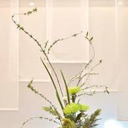

In [14]:
# TODO: look at characteristics/dimensions of the images
for img in imgs:
  width, height = img.size
  print(f"Image dimensions: {width}x{height}")
# TODO: go through the images and make their dimensions consistent
resize_imgs = []
for img in imgs:
  img = img.resize((128, 128))
  resize_imgs.append(img)
# TODO: look at some images
resize_imgs[0].show()

### Create Features

Now that we have images with consistent dimensions, we can extract their pixels and convert them to grayscale, so we get a nice looking `DataFrame` to send to our classifier model.

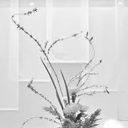

0      1      2      3      4      5      6      7      8      9      \
0      209    209    209    210    211    210    210    210    210    210   
1      214    218    218    215    218    220    209    195    206    219   
2      160    160    160    160    160    160    160    160    160    160   
3      255    255    255    255    255    255    255    255    255    255   
4       44     56     30     11     14     13      9     21     27     46   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
122    238    238    238    238    239    236    237    239    242    255   
123     12     12     12     12     12     12     13     13     13     13   
124     72     54     38     42     26     44     40     69     46     42   
125     78     69     77    103    110     80     70     77     71     81   
126    255    255    255    255    255    255    255    255    255    255   

     ...  16374  16375  16376  16377  16378  16379  16380  16381  16382  16383  
0    ...    254    253    253    250    247    242    237    235    231    231  
1    ...    173    173    173    173    173    171    169    165    163    160  
2    ...     13     18     11     12     23     15     12      7     10     11  
3    ...    255    255    255    255    255    255    255    255    255    255  
4    ...     27     76     75     44     71     68     68     80     96     55  
..   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
122  ...    255    244    236    236    238    238    238    238    238    238  
123  ...     11     11     11     11     12     12     12     12     12     12  
124  ...     21     37     33     40     88     86     62     63     66     38  
125  ...     93     73     62     52     69     69     98    164    165    136  
126  ...    255    255    255    255    255    255    255    255    255    255  

[127 rows x 16384 columns]

In [15]:
# TODO: calculate grayscale pixel values
grayscale_features = []
for img in resize_imgs:
  grayscale_img = img.convert("L") # convert to grayscale
  pixels = get_pixels(grayscale_img)
  grayscale_features.append(pixels)

# TODO: look at some images with make_image()
grayscale_img = make_image(grayscale_features[0])
grayscale_img.show()
# TODO: create DataFrame
grayscale_features_df = pd.DataFrame(grayscale_features)
grayscale_features_df

### Run the Image Model

Now that we have a `DataFrame` with consistent features, we can fit and evaluate our model.

The next cell runs the pre-defined classification model, fitting it with our `features_df` `DataFrame` and then reports the accuracy of our model.

We just have to run it (and wait a bit because it can take up to $20$ seconds for it to run).

In [16]:
# Fit the classifier and report training accuracy
AwesomeImageClassifier.fit(grayscale_features_df, labels)

training accuracy: {'florist': 0.95122, 'forest': 1.0, 'tree': 0.84091, 'overall': 0.93071}


### Scaling / Normalizing

Run the classifier model again, but this time using normalized features.

In [17]:
# TODO: create scaler object, scale data and re-run classification
scaler = StandardScaler()
scaled_features = scaler.fit_transform(grayscale_features_df)
scaled_features_df = pd.DataFrame(scaled_features)
AwesomeImageClassifier.fit(scaled_features_df, labels)

training accuracy: {'florist': 0.95122, 'forest': 1.0, 'tree': 0.86364, 'overall': 0.93829}


### Interpretation

<span style="color:hotpink;">
Do different scaling strategies influence the prediction results ? What might that tell us about our data ?
</span>

<span style="color:hotpink;">
EDIT THIS CELL WITH ANSWER
</span>

## Shazam !

Yep. Let's replicate the Shazam algorithm. It's the same type of classification task we've been looking at, but instead of classifying a piece of audio into one of $3$ classes, the algorithm has to pick which of the millions of songs the piece of audio most likely came from.

We've created some simple classification models by manually extracting features that we think are important for the differentiation of our classes. This is ok if we're only dealing with a few classes, but it doesn't scale. If we had to classify audio into hundreds, or thousands, of classes, looking at graphs of relative frequencies and loudness for all classes becomes intractable.

We need something a little more systematic. Something that automatically extracts meaningful numeric information from audio, independent of the type of audio.

Let's look at the frequency domain again, and use the librosa library to help us extract consistent frequency information from audio files.

## Librosa Feature Extraction

Librosa is useful because it has many feature extraction functions to actually get meaningful frequency information from our audios files:

[Librosa Reference and Documentation](https://librosa.org/doc/latest/feature.html)

### Some example functions

- `librosa.feature.spectral_centroid` (extracts average frequency)
- `librosa.feature.spectral_bandwidth` (extracts frequency range)
- `librosa.feature.spectral_rolloff(roll_percent=0.01)` (extarcts smallest frequency)
- `librosa.feature.spectral_rolloff(roll_percent=0.99)` (extracts largest frequency)

Let's load a song and see what running these looks like:

### ❗️❗️ WARNING ❗️❗️

The songs we'll be using are from mixtapes by [The Hood Internet](https://www.thehoodinternet.com/). They were part of a wave of _mashup_ producers in the early $2\text{,}000\text{s}$ that mixed "_classic_" american indie, pop and rap music from other time periods.

We're using their mixtapes here mostly because: they're available freely on the internet, they encompass a good variety of songs and styles, and there are a good number of songs; not too few nor too many.

The lyrics mostly come from the rap songs being sampled and contain references to all the things that rap artists were rapping about in the $90\text{s}$ and $00\text{s}$ (sex, drugs, guns, money...).

We definitely don't have to listen to the songs to complete the exercise.

And, I am looking for suggestions of alternative "datasets" for this exercise.

### Back to Features Extraction

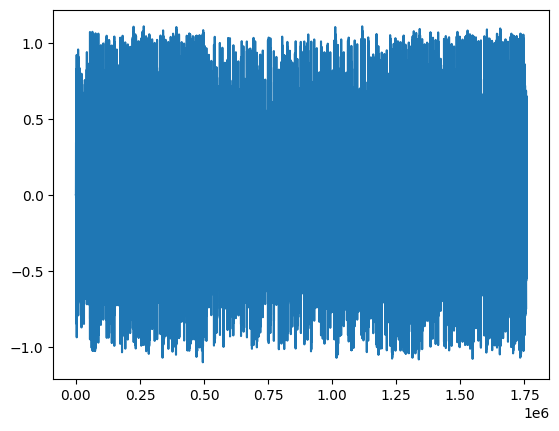

In [18]:
y,sr = librosa.load("./data/audio/hood-internet/mixtape04/02 David Banner x Fujiya & Miyagi - Get Like Pterodactyls.mp3")

plt.plot(y)
plt.show()

display(Audio(y, rate=sr))

This is how we extract the center frequency and the lowest/highest frequencies of our signal, throughout the song.

Because these functions were written to work with multi-channel audio, they'll always return a list of lists. In our case, we just have a single channel, so our result will be at index $0$ of the returned list.

That's why we have `sc[0]`, `smin[0]`, `smax[0]` below.

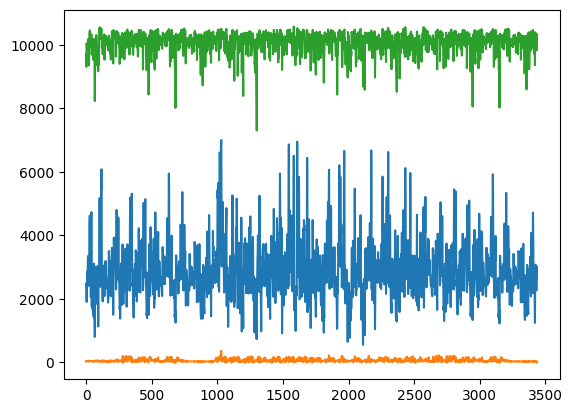

In [19]:
# average frequency
sc = librosa.feature.spectral_centroid(y=y)

# min and max frequencies
smin = librosa.feature.spectral_rolloff(y=y, roll_percent=0.01)
smax = librosa.feature.spectral_rolloff(y=y, roll_percent=0.99)

plt.plot(sc[0])
plt.plot(smin[0])
plt.plot(smax[0])
plt.show()

This is a start.

The functions give us multiple values because the avg/min/max frequency changes over time, but we can average the `spectral_centroid` and the two `spectral_rolloff` frequencies to get $3$ values that represent our entire audio file.

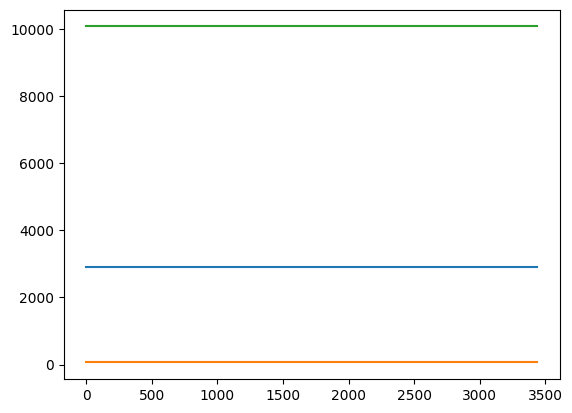

In [20]:
sc_val = sum(sc[0]) / len(sc[0])
smin_val = sum(smin[0]) / len(smin[0])
smax_val = sum(smax[0]) / len(smax[0])

plt.plot([0, len(sc[0])], [sc_val, sc_val])
plt.plot([0, len(smin[0])], [smin_val, smin_val])
plt.plot([0, len(smax[0])], [smax_val, smax_val])
plt.show()

Not bad.

### MFCCs

But, we can extend this idea with Mel-Frequency Cepstral Coefficients (MFCC). MFCCs are a compact, numerical representation of an audio signal's frequency characteristics, that divide an audio frequency range into bands based on human hearing sensitivities. So, instead of just $3$ frequencies, like we got above, the total frequency range is divided into $10$ to $20$ values that represent our audio signal.

And of course `librosa` has an `mfcc()` function:

(10, 3437)


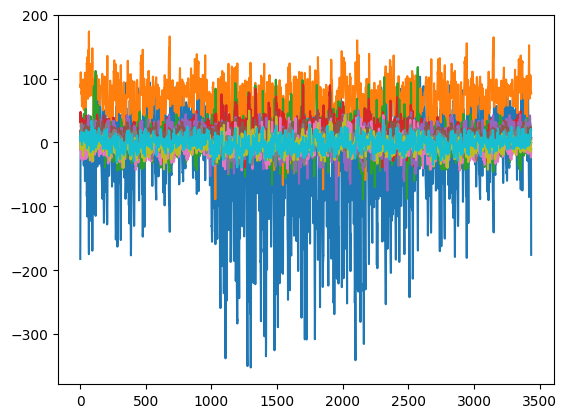

In [21]:
mfccs = librosa.feature.mfcc(y=y, n_mfcc=10)
print(mfccs.shape)

for vs in mfccs:
  plt.plot(vs)
plt.show()

### Average MFCCs

Like the `spectral_centroid()` function, the `mfcc()` function gives us multiple values for each frequency channel/band, since these change over time as the audio changes. We'll assume that one value per frequency band is enough and average them over time, so we end up with only $10$ numbers to represent our audio.

(10,)


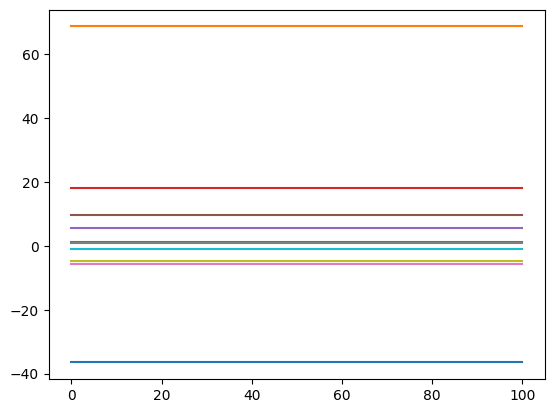

[-36.498466   68.56588     1.1311772  17.951372    5.481598    9.588413
  -5.8382545   0.8165023  -4.6640186  -0.8725709]


In [22]:
mfccs_avg = mfccs.mean(axis=1)
print(mfccs_avg.shape)

for vs in mfccs_avg:
  plt.plot([0,100], [vs, vs])
plt.show()
print(mfccs_avg)

### Back to Shazam

This is what's behind the [Shazam algorithm](https://www.youtube.com/watch?v=b6xeOLjeKs0): a large database of songs, where each song is described with only a few features so they can be organized, searched, queried and compared very very quickly.

Another [video](https://www.youtube.com/watch?v=kMNSAhsyiDg) reference.

Let's implement something like this.

We'll focus on a single album, with about $30$ songs, but the same strategy (with minor modifications) will work for datasets of many more songs.

Here's the outline of what we have to do:

1. Extract MFCC features from all songs in our data base (single album)
2. Create a dataset of song features
3. Given an input sound clip: extract its MFCC features
4. Find closest song in database by feature distance

In [23]:
# First, let's grab all audio file names from our album directory

TRACKS_DIR = "./data/audio/hood-internet/mixtape04"
fnames = sorted([f for f in listdir(TRACKS_DIR) if f.endswith("mp3")])

In [25]:
# Now we define a helper function that:
#   given a list of samples, 
#   returns a dictionary of extracted mfcc values

def get_features(y, n_mfcc=20):
  mfeats = {}
  mfccs = librosa.feature.mfcc(y=y, n_mfcc=n_mfcc).mean(axis=1)
  for idx,fcc in enumerate(mfccs):
    mfeats[f"mfcc{idx}"] = float(fcc)
  return mfeats

{'mfcc0': -36.49846649169922, 'mfcc1': 68.56587982177734, 'mfcc2': 1.1311771869659424, 'mfcc3': 17.951372146606445, 'mfcc4': 5.481597900390625, 'mfcc5': 9.58841323852539, 'mfcc6': -5.838254451751709, 'mfcc7': 0.8165022730827332, 'mfcc8': -4.664018630981445, 'mfcc9': -0.8725708723068237, 'mfcc10': -5.979408264160156, 'mfcc11': 3.1809542179107666, 'mfcc12': -4.455260753631592, 'mfcc13': 0.4618473947048187, 'mfcc14': -0.48798486590385437, 'mfcc15': 1.9746568202972412, 'mfcc16': -6.495473384857178, 'mfcc17': -0.6486953496932983, 'mfcc18': -4.788703441619873, 'mfcc19': -2.6017699241638184}


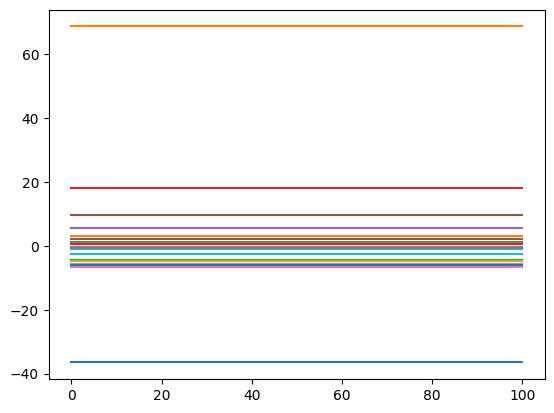

In [31]:
# TODO: run the get_features() function in one of the loaded files
print(get_features(y))
# TODO: check the output and see if it makes sense
for vs in get_features(y).values():
  plt.plot([0,100], [vs, vs])
plt.show()

### 1. Extract MFCC features from all songs

It takes about $20$ seconds to extract features for all songs.

In [34]:
# TODO: Run the function on all tracks and extract their average MFCCs
# TODO: iterate over the list of filenames, open each file,
#       extract mfcc features and append result to a list


track_feats = []
for fname in fnames:
  y, sr = librosa.load(f"{TRACKS_DIR}/{fname}")
  track_feats.append(get_features(y))
track_feats

[{'mfcc0': -82.5860595703125,
  'mfcc1': 79.53273010253906,
  'mfcc2': 15.281947135925293,
  'mfcc3': 29.399259567260742,
  'mfcc4': 6.727076530456543,
  'mfcc5': 11.497275352478027,
  'mfcc6': -0.07376781105995178,
  'mfcc7': 11.575368881225586,
  'mfcc8': -3.0110397338867188,
  'mfcc9': 10.090432167053223,
  'mfcc10': -0.660233199596405,
  'mfcc11': 3.245026111602783,
  'mfcc12': 1.0927025079727173,
  'mfcc13': 1.2003700733184814,
  'mfcc14': -1.564979910850525,
  'mfcc15': 3.8272948265075684,
  'mfcc16': -3.1707167625427246,
  'mfcc17': 1.2720928192138672,
  'mfcc18': -2.1068079471588135,
  'mfcc19': 1.5617727041244507},
 {'mfcc0': -36.49846649169922,
  'mfcc1': 68.56587982177734,
  'mfcc2': 1.1311771869659424,
  'mfcc3': 17.951372146606445,
  'mfcc4': 5.481597900390625,
  'mfcc5': 9.58841323852539,
  'mfcc6': -5.838254451751709,
  'mfcc7': 0.8165022730827332,
  'mfcc8': -4.664018630981445,
  'mfcc9': -0.8725708723068237,
  'mfcc10': -5.979408264160156,
  'mfcc11': 3.180954217910766

### 2. Create `DataFrame` of song features

In [42]:
# TODO: put results in pandas DataFrame using the from_records() function
tracks_df = pd.DataFrame.from_records(track_feats)
tracks_df

mfcc0       mfcc1      mfcc2      mfcc3      mfcc4      mfcc5  \
0  -82.586060   79.532730  15.281947  29.399260   6.727077  11.497275   
1  -36.498466   68.565880   1.131177  17.951372   5.481598   9.588413   
2  -14.431624   91.889542 -17.692987  20.666237   2.245853  13.001684   
3  -62.079441   79.199989   5.043945  10.326107  14.655840   3.606573   
4   -0.747465   92.354622   0.195784  16.982300   6.918648  15.270939   
5  -35.664974   73.733498   4.196826  16.117207   0.898156   6.703715   
6  -34.479401   71.243324  11.187264  11.472790   4.763395   8.362548   
7  -28.663395   83.778824  11.784966  25.143528  10.610123  13.076379   
8  -25.007885   70.711952   6.459869  24.236881   9.859155   9.727757   
9  -15.857485   87.658066 -22.861092  33.988007  -3.307864  11.846355   
10  -4.816902   73.394295 -11.744067  16.182905  -1.195409   7.034644   
11 -29.519230   65.085464  -7.447930  12.881835   1.666066   9.112345   
12  -7.522346   60.339634  -0.123692  28.313770   5.176182  10.398970   
13   4.097200   78.657806  -2.644476  19.867725   4.517694   4.408960   
14 -32.900703   80.994690 -10.389856  28.350649  -1.721534  11.481354   
15 -27.485617   71.073044  -7.953963  26.335247   6.523619   7.762288   
16 -13.566113   81.105560  -2.128357  20.265041   2.747745  12.105445   
17  17.434723   66.161331  -1.521091  22.956198  -2.942046   5.832578   
18 -32.126461   87.396271  16.129730  21.892687  10.936379  -1.211902   
19 -12.415400   69.552597  -1.925810  31.155470  11.977099  11.331101   
20  -8.647201   95.706314   1.616024  20.072241   5.667694   8.149070   
21 -24.040487   82.670654  -4.516219  16.085640   0.976224   4.632704   
22  -9.554897   75.698524  17.002012  17.270782   9.815242   8.568609   
23 -35.787189   76.744698  -9.697543  26.043674  11.120592   4.294749   
24 -20.419727  101.548347 -19.839195  25.586359  -4.314030   1.256504   
25   4.672899   97.109245 -22.924541  10.200262  14.198112  -5.017467   
26 -63.396435   92.530342  13.383127 -10.581464   5.725403   4.169705   
27 -32.051910   73.294113   0.040295   4.226750   1.141478   4.998079   
28 -15.369833   85.858727 -10.594419  18.089779  -2.311863   4.803858   
29 -23.398849   85.828751 -13.302974  16.491570   5.116549   6.341559   
30 -29.581385   89.890945   9.728170  16.739216   3.601286   9.826908   
31 -19.680706  102.471611 -10.552818  29.865934   1.056105  10.864219   
32 -15.195163   94.775757   5.371995  14.047431  10.663271   4.051098   
33 -93.544777   84.444351 -18.454889   5.706397  -0.603504  -2.439888   

        mfcc6      mfcc7      mfcc8      mfcc9    mfcc10    mfcc11    mfcc12  \
0   -0.073768  11.575369  -3.011040  10.090432 -0.660233  3.245026  1.092703   
1   -5.838254   0.816502  -4.664019  -0.872571 -5.979408  3.180954 -4.455261   
2   -1.321214   9.948377  -0.615950  11.860087  1.530263  6.526819 -1.141762   
3   -6.818017   7.708108  -0.689195   3.924184 -2.623504  3.656586 -4.205101   
4   -1.317757   7.606240  -1.518143   5.708029  0.671459  4.795196 -1.870469   
5   -1.960575   4.447550  -1.939743   5.270139 -5.431313  2.591826 -2.935765   
6   -0.957873   5.603895  -2.738507   0.952181 -2.665535  2.161973  0.253431   
7    1.660900   8.122109   1.959449   7.608665  3.474735  7.115009  4.217964   
8    3.846369   7.556618  -2.184863   6.845351 -1.877875  5.675496 -0.284641   
9    3.919635   6.607801   0.544680   8.447746  0.931829  6.537024 -1.623442   
10  -1.830201   4.955759  -5.473131   9.254018  1.904559  5.996353 -2.554131   
11   1.624684   7.835165  -3.832475   9.614503 -0.794344  1.012886 -3.473338   
12  -1.223050   5.750009   2.255568   4.546013  2.031981  3.700882  4.109806   
13  -5.419432   2.935398  -1.770762   1.615597 -6.411483 -2.558482 -3.248969   
14   0.108594   8.840305  -1.163880   4.886731 -1.508366  4.383626 -4.010222   
15  -0.615533   8.726112  -1.805470   8.535130 -3.722814  5.306087 -0.612607   
16   0.518556   0.980654  -4.380493   2.043630  0.859926  1.054461 -1.805910   
17  -2.72284

### 3. Given an input sound clip: extract its MFCC features

In [36]:
# Let's open track 02 (index 1) and get 5 seconds of audio from the center of the song

# Track 02
fpath = f"{TRACKS_DIR}/{fnames[1]}"
y_in, sr_in = librosa.load(fpath)

# get 5 seconds from middle of song
midx = int(len(y_in) // 2)
half_win = int(2.5 * sr_in)
samples_5sec = y_in[midx - half_win : midx + half_win]

feat_in = [get_features(samples_5sec)]

# And create DataFrame with MFCC features for the 5-second clip
in_df = pd.DataFrame.from_records(feat_in)
in_df

mfcc0      mfcc1     mfcc2      mfcc3     mfcc4      mfcc5     mfcc6  \
0 -70.567818  66.446526  7.160023  20.282223 -3.914236  11.563001  0.506436   

      mfcc7     mfcc8     mfcc9    mfcc10    mfcc11    mfcc12    mfcc13  \
0 -2.514076 -1.906371 -3.218599 -8.286109  1.775437 -6.402539  0.362845   

    mfcc14    mfcc15    mfcc16    mfcc17    mfcc18    mfcc19  
0 -3.93689 -0.223839 -7.139868 -1.340939 -4.915074 -2.377215

### 4. Find closest song in database by feature distance

Because both our dataset of song features and the features from the input clip we want to find are in `DataFrames`, we can do some `DataFrame` math to quickly calculate the difference between the input clip features and features from all of the songs in our song database. We'll use this to find the row in our dataset that is closest to the input audio.

We can start the process with this line of code:
```py
dists = (tracks_df - in_df.iloc[0]).abs().sum(axis=1)
```

Pretty intense. Let's break it down:

- `tracks_df - in_df.iloc[0]`: this subtracts the first (and only) row of the input `DataFrame` from every row of the song dataset. The result is another `DataFrame` with $34$ rows and $20$ columns, where the cells don't hold MFCC values anymore, but the difference between the values in the input clip and the values from the songs in the dataset.

- `.abs()`: the absolute value of the difference. After the subtraction, some of the values might be negative, but we only care about their magnitude; how different they are, and not which is larger/smaller. The result is another `DataFrame` of the same size as the previous, but now all values are positive.

- `.sum(axis=1)`: this sums the differences across the columns. The result is a `DataFrame` with $34$ rows and a single column with a value that represents how different each of the songs in the dataset is from the input clip. The larger the number, the more different the song is.

What we still have to do is find out which row has the shortest distance to our input clip.

We can do this in a variety of ways.

One possibility is to just loop over the values and use $2$ variables to keep track of the smallest difference value and the index of where that difference is.

A more general approach is to turn our `DataFrame` into a list of pairs of row indexes and difference values:

```py
[[0, difference], [1, difference], [2, difference], ...]
```

and sort by the difference values. As we'll see below, this approach has advantages.

We can turn our single-column `dists` `DataFrame` into a list like this using the `.to_dict()` function followed by the `.items()`.

The `.to_dict()` function turns the single-column `DataFrame` into a `Python` dictionary, like this:
```py
{
  0: difference,
  1: difference,
  2: difference,
  ...
}
```

And the `items()` function is the regular `Python` dictionary that gives us dictionary (`key`,`value`) pairs.

In [43]:
dists = (tracks_df - in_df.iloc[0]).abs().sum(axis=1)
idx_dist_pairs = dists.to_dict().items()

# break these down into multiple steps and see if each step makes sense
(tracks_df - in_df.iloc[0]) # add abs, sum, to_dict and items one at a time

mfcc0      mfcc1      mfcc2      mfcc3      mfcc4      mfcc5  \
0  -12.018242  13.086205   8.121924   9.117037  10.641313  -0.065725   
1   34.069351   2.119354  -6.028846  -2.330851   9.395834  -1.974587   
2   56.136193  25.443016 -24.853011   0.384014   6.160089   1.438684   
3    8.488377  12.753464  -2.116078  -9.956116  18.570076  -7.956428   
4   69.820352  25.908096  -6.964239  -3.299923  10.832884   3.707938   
5   34.902843   7.286972  -2.963198  -4.165016   4.812392  -4.859286   
6   36.088417   4.796799   4.027241  -8.809433   8.677631  -3.200453   
7   41.904423  17.332298   4.624943   4.861305  14.524359   1.513378   
8   45.559933   4.265427  -0.700154   3.954659  13.773391  -1.835244   
9   54.710333  21.211540 -30.021115  13.705784   0.606372   0.283355   
10  65.750916   6.947769 -18.904090  -4.099318   2.718827  -4.528357   
11  41.048588  -1.361061 -14.607954  -7.400388   5.580302  -2.450656   
12  63.045471  -6.106892  -7.283715   8.031548   9.090418  -1.164031   
13  74.665018  12.211281  -9.804500  -0.414497   8.431931  -7.154041   
14  37.667114  14.548164 -17.549880   8.068426   2.192702  -0.081647   
15  43.082201   4.626518 -15.113986   6.053024  10.437855  -3.800713   
16  57.001704  14.659035  -9.288380  -0.017181   6.661981   0.542444   
17  88.002541  -0.285194  -8.681114   2.673975   0.972190  -5.730423   
18  38.441357  20.949745   8.969707   1.610464  14.850616 -12.774903   
19  58.152418   3.106071  -9.085833  10.873247  15.891335  -0.231899   
20  61.920617  29.259789  -5.543999  -0.209982   9.581930  -3.413931   
21  46.527330  16.224129 -11.676242  -4.196583   4.890460  -6.930296   
22  61.012920   9.251999   9.841989  -3.011440  13.729478  -2.994391   
23  34.780628  10.298172 -16.857566   5.761452  15.034828  -7.268251   
24  50.148090  35.101822 -26.999218   5.304136  -0.399794 -10.306497   
25  75.240716  30.662720 -30.084565 -10.081961  18.112349 -16.580468   
26   7.171383  26.083817   6.223104 -30.863687   9.639639  -7.393296   
27  38.515907   6.847588  -7.119728 -16.055472   5.055714  -6.564921   
28  55.197985  19.412201 -17.754443  -2.192444   1.602373  -6.759142   
29  47.168968  19.382225 -20.462997  -3.790653   9.030785  -5.221441   
30  40.986433  23.444420   2.568147  -3.543007   7.515522  -1.736093   
31  50.887112  36.025085 -17.712842   9.583712   4.970341  -0.698782   
32  55.372655  28.329231  -1.788028  -6.234792  14.577507  -7.511903   
33 -22.976959  17.997826 -25.614913 -14.575826   3.310732 -14.002888   

        mfcc6      mfcc7      mfcc8      mfcc9     mfcc10    mfcc11  \
0   -0.580203  14.089445  -1.104669  13.309031   7.625876  1.469589   
1   -6.344690   3.330578  -2.757648   2.346028   2.306701  1.405517   
2   -1.827650  12.462453   1.290421  15.078687   9.816372  4.751382   
3   -7.324453  10.222184   1.217175   7.142783   5.662605  1.881149   
4   -1.824193  10.120316   0.388228   8.926629   8.957568  3.019758   
5   -2.467010   6.961626  -0.033372   8.488738   2.854796  0.816389   
6   -1.464308   8.117971  -0.832137   4.170781   5.620574  0.386536   
7    1.154464  10.636185   3.865819  10.827264  11.760844  5.339572   
8    3.339933  10.070694  -0.278493  10.063950   6.408234  3.900059   
9    3.413199   9.121877   2.451050  11.666346   9.217938  4.761586   
10  -2.336637   7.469835  -3.566761  12.472617  10.190668  4.220916   
11   1.118248  10.349241  -1.926105  12.833102   7.491765 -0.762551   
12  -1.729486   8.264085   4.161938   7.764612  10.318090  1.925445   
13  -5.925868   5.449474   0.135609   4.834196   1.874626 -4.333919   
14  -0.397841  11.354381   0.742490   8.105330   6.777743  2.608188   
15  -1.121969  11.240188   0.100901  11.753729   4.563295  3.530650   
16   0.012120   3.494730  -2.474122   5.262229   9.146035 -0.720976   
17  -3.229277  10.410762  -2.967820   8.839242   5.242866  2.642384   
18   4.647345   2.490529  -2.828463  10.192690   6.209555  4.117944   
19  -7.001969   9.110272   2.733893   6.199654   7.068629  3.419938

We still have to sort our distance pairs

In [ ]:
# TODO: sort the idx_dist_pairs list by the difference values
# TODO: after sorting, look at the first item and check if the index matches the index of the input song
sort_list = sorted(idx_dist_pairs, key=lambda x: x[1])
sort_list[0]

(1, 83.7912315428257)

### 5. Evaluate

We should calculate how often our Shazam algorithm is right.

This can be done by implementing the following set of steps:
1. Initialize a counter to keep track of number of correct predictions
2. For $N$ predictions (where $N$ can be $10$, $100$, $1000$, etc ...)
3. Pick a random track from the album
4. Pick a random $5$ second clip from the random track
5. Extract features, compare to features in `tracks_df` and predict which track it is
6. If prediction correct, increment correct predictions counter

Alternatively, instead of only incrementing the correct predictions counter when the correct track is the very first on the list of possible tracks, we can increment the counter if the correct track is in the $\text{top-}3$ predictions. This is the $\text{top-}3$ accuracy of our classifier, which, instead of being a binary measurement of right/wrong, also gives us a bit of credit for being "close".

In [75]:
# TODO: write a function called random5() that
#       receives an audio file path, extracts MFCC features from 
#       a random 5-second portion of the audio and returns a DataFrame with the features
def random5(fpath):
  y, sr = librosa.load(fpath)
  span = int(5 * sr)

  if len(y) < span:
      samples_5sec = y
  else:
      start = random.randrange(0, len(y) - span)
      samples_5sec = y[start : start + span]

  return pd.DataFrame.from_records([get_features(samples_5sec)])

  # TODO: implement here. random.randrange() can help


We'll also need a function for comparing the `DataFrame` of songs and the `DataFrame` of the input clip.

We just have to wrap the mega-line of `Pandas` and the sorting from above in a function.

In [69]:
# TODO: implement comparison function
def compare_predict(tracks_df, in_df):
  
  # implement here
  dists = (tracks_df - in_df.iloc[0]).abs().sum(axis=1)
  idx_dist_pairs = list(dists.to_dict().items())
  # sort by distance (smallest = most similar)
  sorted_pairs = sorted(idx_dist_pairs, key=lambda x: x[1])
  return sorted_pairs

Now we use the above defined functions to run some tests.

We'll want to run $200$ to $500$ tests, but we can start with $10$ or so just to make sure the code works.

In [82]:
# TODO: pick a random song
# TODO: extract features from random 5-second clip of song
# TODO: compare, and keep track of correct predictions
# TODO: repeat
# TODO: print accuracy (number of correct predictions divided by total tests)
# ...existing code...
from os.path import join
TRACKS_DIR = "./data/audio/hood-internet/mixtape04"
fnames = sorted([f for f in listdir(TRACKS_DIR) if f.endswith(".mp3")])
fpaths = [join(TRACKS_DIR, f) for f in fnames]

tracks_rows = []
for fp in fpaths:
    clip_df = random5(fp)                      # 1-row df
    tracks_rows.append(clip_df.iloc[0].to_dict())

tracks_df = pd.DataFrame.from_records(tracks_rows)

def evaluate(tracks_df, fpaths, N=100):
    correct_top1 = 0
    correct_top3 = 0

    for _ in range(N):
        true_idx = random.randrange(len(fpaths))
        fpath = fpaths[true_idx]

        in_df = random5(fpath)
        results = compare_predict(tracks_df, in_df)

        top1 = results[0][0]
        top3 = [r[0] for r in results[:3]]

        if top1 == true_idx:
            correct_top1 += 1
        if true_idx in top3:
            correct_top3 += 1

    print("Top-1 accuracy:", correct_top1 / N)
    print("Top-3 accuracy:", correct_top3 / N)

evaluate(tracks_df, fpaths, N=100)



Top-1 accuracy: 0.34
Top-3 accuracy: 0.51


### Improve the Algorithm ?

Not bad.

(Re)Watch the Shazam video [here](https://www.youtube.com/watch?v=b6xeOLjeKs0). What's the one big difference between their algorithm and ours ?

(You don't have to improve the code. Just think about what could be some potential next steps.)